# Basic Least Squares Fit  Example in Python using iminuit

Fitting example using iminuit (https://iminuit.readthedocs.io). iminuit can be installed with ` pip install iminuit`. [Minuit](https://en.wikipedia.org/wiki/MINUIT) is a robust numerical minimization program written by CERN physicist Fred James in 1970s. It is widely used in particle physics.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
from pprint import pprint

### Define data

In [3]:
xd = np.array([1., 2., 3., 4., 5.])
yd = np.array([1.7, 2.3, 3.5, 3.3, 4.3])
yd_err = np.array([0.5, 0.3, 0.4, 0.4, 0.6])

### Define fit function

In [4]:
def f(x, theta0, theta1):
    return theta0 + theta1*x

### Define $\chi^2$ function

Minuit finds the minimum of a multi-variate function. We need to define a $\chi^2$ function which is then minimized by iminuit.

In [5]:
def chi2(theta0, theta1):
    fy = f(xd, theta0, theta1)
    diffs = (yd - fy) / yd_err
    return np.sum(diffs**2)

### Initialize minuit and perform the fit

In [6]:
# m = Minuit(chi2, theta0=1, theta1=0.5, error_theta0=0.01, error_theta1=0.01, errordef=Minuit.LEAST_SQUARES)
m = Minuit(chi2, theta0=1, theta1=0.5, error_theta0=0.01, error_theta1=0.01, errordef=Minuit.LEAST_SQUARES)

In [7]:
m.migrad()

------------------------------------------------------------------
| FCN = 2.296                   |      Ncalls=30 (30 total)      |
| EDM = 3.9e-23 (Goal: 0.0002)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
--------------------------------------------------------------------------------------------
|   | Name   |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
--------------------------------------------------------------------------------------------
| 0 | theta0 |    1.2    |    0.5    |            |            |         |         |       |
| 1 | theta1 |   0.61    |   0.15    |            |            |         |         |       |
--------------------------------------------------------------------------------------------

In [8]:
for p in m.parameters:
    print(f"{p} = {m.values[p]:.6f}" \
          f" +/- {m.errors[p]:.6f}")

theta0 = 1.162066 +/- 0.459550
theta1 = 0.613945 +/- 0.153005


In [9]:
# covariance matrix
print(m.np_covariance())

[[ 0.21118628 -0.06460344]
 [-0.06460344  0.02341046]]


In [10]:
# covariance matrix
m.matrix()

--------------------------
|        | theta0 theta1 |
--------------------------
| theta0 |  0.211 -0.065 |
| theta1 | -0.065  0.023 |
--------------------------

In [11]:
# correlation matrix
m.matrix(correlation=True)

--------------------------
|        | theta0 theta1 |
--------------------------
| theta0 |  1.000 -0.919 |
| theta1 | -0.919  1.000 |
--------------------------

### Plot data along with fit function

In [12]:
xf = np.linspace(0., 6., 1000)
theta0 = m.values["theta0"]
theta1 = m.values["theta1"]
yf = f(xf, theta0, theta1)

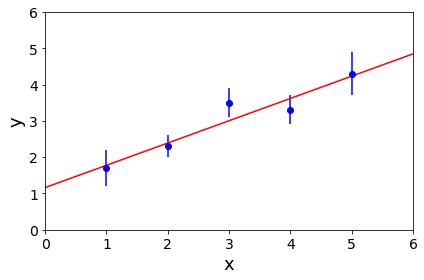

In [13]:
plt.xlabel("x", fontsize=18)
plt.ylabel("y", fontsize=18)
plt.errorbar(xd, yd, yerr=yd_err, fmt="bo")
plt.xlim(0., 6.)
plt.ylim(0., 6.)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.plot(xf, yf, color="red")
plt.tight_layout()
# plt.savefig("basic_chi2_fit_plot1.pdf")

### Calculate the $\chi^2$ per degree of freedom and p-value

In [14]:
from scipy import stats

chi2 = m.fval

n_data_points = xd.size
n_fit_parameters = 2
n_dof = n_data_points - n_fit_parameters
pvalue = 1 - stats.chi2.cdf(chi2, n_dof)

print(f"chi2/ndf = {chi2:.1f} / {n_dof}, p-value = {pvalue:.3f}")

chi2/ndf = 2.3 / 3, p-value = 0.513


### Error ellipse

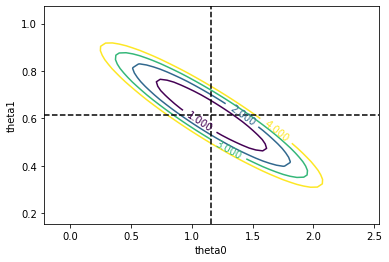

In [15]:
m.draw_contour('theta0','theta1', bound=3);

In [16]:
def get_error_ellipse(cov, center, nstd, **kwargs):
    """
    return error ellipse patch representing the covariance matrix
    cov: 2x2 covariance matrix
    centre: mean values (mu1, mu2)
    nstd: number of standard deviations
    """

    # eigenvalues and eigenvectors of the covariance matrix
    # (in ascending order of the eigenvalue)
    eigvals, eigvecs = np.linalg.eigh(cov)
   
    # x, y component of the eigenvector (eigvecs[:,1]) with the larger eigenvalue
    x, y = eigvecs[:,1][0], eigvecs[:,1][1]
    
    # angle of the ellipse    
    theta = np.arctan2(y, x)
    
    # width = 2 times radius in x, height = 2 times radius in y 
    height, width = 2 * nstd * np.sqrt(eigvals)
        
    return Ellipse(xy=center, width=width, height=height,
                   angle=np.degrees(theta), **kwargs)


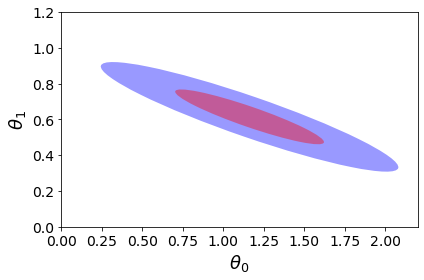

In [17]:
from matplotlib.patches import Ellipse
fig, ax = plt.subplots()
el_1sigma = get_error_ellipse(m.np_covariance(), (theta0, theta1), 1, fc='red', alpha=0.4)
el_2sigma = get_error_ellipse(m.np_covariance(), (theta0, theta1), 2, fc='blue', alpha=0.4)
ax.add_artist(el_2sigma)
ax.add_artist(el_1sigma)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.set_xlim(0., 2.2)
ax.set_ylim(0., 1.2)
plt.xlabel(r"$\theta_0$", fontsize=18)
plt.ylabel(r"$\theta_1$", fontsize=18)
plt.tight_layout()
plt.savefig("basic_chi2_fit_plot2.pdf")

### Error band around fit function (propagation of fit parameter uncertainties)

In [18]:
# error propagation of the uncertainties of the fit parameters (see lecture slides)
Var_yf = m.np_covariance()[1][1] * xf**2 + 2. * m.np_covariance()[1][0] * xf + m.np_covariance()[0][0]
sigma_yf = np.sqrt(Var_yf)

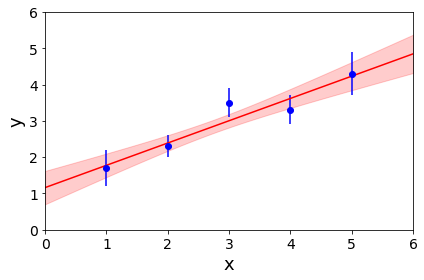

In [19]:
fig, ax = plt.subplots()
plt.xlabel("x", fontsize=18)
plt.ylabel("y", fontsize=18)
plt.errorbar(xd, yd, yerr=yd_err, fmt="bo")
ax.fill_between(xf, yf - sigma_yf, yf + sigma_yf, alpha=0.2, color='red')
plt.xlim(0., 6.)
plt.ylim(0., 6.)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.plot(xf, yf, color="red")
plt.tight_layout()
# plt.savefig("basic_chi2_fit_plot3.pdf")